## Project Title -Detecting Toxic Comments using NLP 
This project aims to mitigate the negative impacts of online hate comments and fake news within households, with a focus on protecting children who may have limited technology expertise. It specifically addresses three types of online hate comments: 
- Community-based
- Religion-based 
- Gender-based

The project involved collecting user data from online sources, training and analyzing datasets, and annotating 400,000+ sentences with risk levels (non-risky or risky). Additionally, data pre-processing and the development of a machine learning model to detect risky behavior are key components of the project.

## Step 1 Data cleaning & merging from different sources
List of the datasets which I will use:

1. Zampieri2019: Offensive Posts in Social Media
2. Malignant comments clean


The pre-processing to create 'clean_sentence_training' column in data will involve the following steps:

1. delete all rows containing null values
2. stopwords removal
3. removal of digits and words containing digits, punctuation and special characters, extra spaces, web links etc
4. lemmatization

I did not change the case of the sentences as the distinction between lowercase and uppercase can be meaningful in this context(based on the discussion with modelling team).
The pre-processing for the 'clean_sentence_EDA' will involve all the steps above, plus the deletion of all emojis (if present).

The labels will be:

    '1' for RISKY sentences (eg., 'hateful' or 'abusive');
    '0' for NON RISKY sentences.

In [76]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import emoji
import re

In [77]:

# Dataset 1. Zampieri2019: Offensive Posts in Social Media
  
# this dataset has only two labels so I used risky and non-risky (no potentially risky sentence)
df = pd.read_csv("./veer_sub/zampieri2019/zampieri2019en.csv", sep="\t") 
df.head()


,id,text,labels
0,0,@USER She should ask a few native Americans wh...,['offensive']
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,['offensive']
2,2,Amazon is investigating Chinese employees who ...,['none']
3,3,"@USER Someone should'veTaken"" this piece of sh...",['offensive']
4,4,@USER @USER Obama wanted liberals &amp; illega...,['none']


In [78]:
df['labels'].value_counts()

['none']         8840
['offensive']    4400
Name: labels, dtype: int64

In [79]:
# Create new labels in the cleaned_dataset colunm

df['new_labels'] = df['labels'].replace({"['offensive']":'too risky', "['none']" : "non risky"})
df.head()


,id,text,labels,new_labels
0,0,@USER She should ask a few native Americans wh...,['offensive'],too risky
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,['offensive'],too risky
2,2,Amazon is investigating Chinese employees who ...,['none'],non risky
3,3,"@USER Someone should'veTaken"" this piece of sh...",['offensive'],too risky
4,4,@USER @USER Obama wanted liberals &amp; illega...,['none'],non risky


In [80]:

#convert labels into numerical format as 
df['numeric_labels'] = df['new_labels'].replace({"non risky":'0',"too risky":'2'})
df.head()


,id,text,labels,new_labels,numeric_labels
0,0,@USER She should ask a few native Americans wh...,['offensive'],too risky,2
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,['offensive'],too risky,2
2,2,Amazon is investigating Chinese employees who ...,['none'],non risky,0
3,3,"@USER Someone should'veTaken"" this piece of sh...",['offensive'],too risky,2
4,4,@USER @USER Obama wanted liberals &amp; illega...,['none'],non risky,0


In [81]:

# Cleaning Sentence
df.isnull().sum() # checking for null values # Identify null rows or zero in the dataset
df.dropna(axis=0,inplace=True) # dropping null from dataset
print(f"how many missing value in the dataset {df.isnull().any().sum()}")

how many missing value in the dataset 0


In [82]:
def extract_emojis(s):
    """Checks if there are any emojis present and removes them from the input text

    Args:
        s (pandas series): column containing the texts
    Returns:
        result (str) : input text with emojis removed
    """
    # Initialize an empty string to store the text without emojis
    result = ''

    # Iterate over each character in the input text
    for c in s:
        # Check if the character is an emoji by using the `in` operator with `emoji.EMOJI_DATA`
        if c not in emoji.EMOJI_DATA:
            # If the character is not an emoji, append it to the `result` string
            result += c
    
    # Return the final `result` string with emojis removed
    return result

In [83]:
df['text'] = df['text'].apply(extract_emojis)

In [84]:
# Sentence cleaning using RegX
def clean_text(text):

    text = re.sub('\d+','', text)  # Remove digits from the text
    text = re.sub('&amp;',' ',text) # Replace '&amp;' with a space
    text = re.sub('URL',' ',text) # Replace 'URL' with a space
    text = re.sub('[^a-zA-Z]+', ' ', text)  # Remove non-alphabetic characters and replace them with a space
    text = re.sub('/(\s\s\s*)/g', ' ',text) # Replace consecutive spaces with a single space;\s represents a whitespace character (e.g., space, tab, newline).
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove URLs starting with 'http', 'https', or 'www'
    text = re.sub('USER','',text)  # Replace 'USER' with an empty space
    return text



In [85]:
df['cleaned_texts'] = df['text'].apply(clean_text)
df.head()

,id,text,labels,new_labels,numeric_labels,cleaned_texts
0,0,@USER She should ask a few native Americans wh...,['offensive'],too risky,2,She should ask a few native Americans what t...
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,['offensive'],too risky,2,Go home you re drunk MAGA Trump
2,2,Amazon is investigating Chinese employees who ...,['none'],non risky,0,Amazon is investigating Chinese employees who ...
3,3,"@USER Someone should'veTaken"" this piece of sh...",['offensive'],too risky,2,Someone should veTaken this piece of shit to...
4,4,@USER @USER Obama wanted liberals &amp; illega...,['none'],non risky,0,Obama wanted liberals illegals to move into...


In [86]:
#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [87]:
#select only the cleaned_texts column
texts = df['cleaned_texts']
#convert to dataframe
texts = pd.DataFrame(texts)
#create empty list to hold the final output
corpus = []
#loop through each row of comments
for i in range(0, len(texts)):
    #tokenize the text
    review = texts['cleaned_texts'][i].split()
    #remove stopwords and lemmatize
    text_stopwords_lemmatized = [lemmatizer.lemmatize(word) for word in review if not word.lower() in stopwords.words('english')]
    #combine the tokenized texts
    text_stopwords_lemmatized = ' '.join(text_stopwords_lemmatized)
    #put final result into the corpus list
    corpus.append(text_stopwords_lemmatized)

In [88]:
#create dataframe with the appropriate name as accoridng to repo guidelines
corpus = pd.DataFrame(corpus, columns=['clean_sentence_training'])

In [89]:
#merge the main dataframe with the cleaned one
df = pd.concat([df, corpus], axis=1)

In [90]:
df.head()

,id,text,labels,new_labels,numeric_labels,cleaned_texts,clean_sentence_training
0,0,@USER She should ask a few native Americans wh...,['offensive'],too risky,2,She should ask a few native Americans what t...,ask native Americans take
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,['offensive'],too risky,2,Go home you re drunk MAGA Trump,Go home drunk MAGA Trump
2,2,Amazon is investigating Chinese employees who ...,['none'],non risky,0,Amazon is investigating Chinese employees who ...,Amazon investigating Chinese employee selling ...
3,3,"@USER Someone should'veTaken"" this piece of sh...",['offensive'],too risky,2,Someone should veTaken this piece of shit to...,Someone veTaken piece shit volcano
4,4,@USER @USER Obama wanted liberals &amp; illega...,['none'],non risky,0,Obama wanted liberals illegals to move into...,Obama wanted liberal illegals move red state


In [91]:
#rename columns to match the appropriate format requested in the repo
df = df.rename(columns={'cleaned_texts':'raw_sentence','numeric_labels':'label'})
df['corpus_name'] = 'zampieri2019: Offensive Posts in Social Media'
df['clean_sentence_EDA'] = df['clean_sentence_training']

In [92]:
#select only relevant columns
df = df [['corpus_name','raw_sentence','label','clean_sentence_training','clean_sentence_EDA']]

In [93]:
df.to_csv("./veer_sub/zampieri2019_offensive_Posts_in_Social_Media.csv")

In [94]:
df=pd.read_csv("./veer_sub/zampieri2019_offensive_Posts_in_Social_Media.csv")


In [95]:
df.head(3)


,Unnamed: 0,corpus_name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,0,zampieri2019: Offensive Posts in Social Media,She should ask a few native Americans what t...,2,ask native Americans take,ask native Americans take
1,1,zampieri2019: Offensive Posts in Social Media,Go home you re drunk MAGA Trump,2,Go home drunk MAGA Trump,Go home drunk MAGA Trump
2,2,zampieri2019: Offensive Posts in Social Media,Amazon is investigating Chinese employees who ...,0,Amazon investigating Chinese employee selling ...,Amazon investigating Chinese employee selling ...


In [96]:
df['label'].value_counts()

0    8840
2    4400
Name: label, dtype: int64

In [97]:
# Dataset 2. Malignant comments clean

df2 = pd.read_csv("./veer_sub/data_huang_devansh.csv") # this dataset has only two labels so I used risky and non-risky (no potentially risky sentence)
df2.head(5)

,Content,Label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


In [98]:
df2['Label'].value_counts()

0    708641
1    133694
Name: Label, dtype: int64

In [99]:
df2.rename(columns={'Label': 'labels'}, inplace=True)# reusing the cleaning steps so renaming
df2.rename(columns={'Content': 'text'}, inplace=True)# same as above

In [100]:
# Create new labels in the cleaned_dataset colunm

df2['new_labels'] = df2['labels'].replace({"['offensive']":'too risky', "['none']" : "non risky"})
df2.head()


,text,labels,new_labels
0,`- This is not ``creative``. Those are the di...,0,0
1,` :: the term ``standard model`` is itself le...,0,0
2,"True or false, the situation as of March 200...",0,0
3,"Next, maybe you could work on being less cond...",0,0
4,This page will need disambiguation.,0,0


In [101]:

#convert labels into numerical format as 
df2['numeric_labels'] = df2['new_labels'].replace({"non risky":'0',"too risky":'2'})
df2.head()


,text,labels,new_labels,numeric_labels
0,`- This is not ``creative``. Those are the di...,0,0,0
1,` :: the term ``standard model`` is itself le...,0,0,0
2,"True or false, the situation as of March 200...",0,0,0
3,"Next, maybe you could work on being less cond...",0,0,0
4,This page will need disambiguation.,0,0,0


In [102]:

# Cleaning Sentence
df2.isnull().sum() # checking for null values # Identify null rows or zero in the dataset
df2.dropna(axis=0,inplace=True) # dropping null from dataset
print(f"how many missing value in the dataset {df2.isnull().any().sum()}")

how many missing value in the dataset 0


In [103]:
df2= df2[:400000]
# orignal dataset had 708641 non risky and 133694 risky comments.
# due to limited compute capacity i have reduce the dataset.
# There are better way to reduce the dataset using various cross validation technique 
# but I have not used it in this project. 

In [104]:
df2['labels'].value_counts()


0    353480
1     46520
Name: labels, dtype: int64

In [105]:
df2['text'] = df2['text'].apply(extract_emojis)

In [106]:
df2['cleaned_texts'] = df2['text'].apply(clean_text)
df2.head()

,text,labels,new_labels,numeric_labels,cleaned_texts
0,`- This is not ``creative``. Those are the di...,0,0,0,This is not creative Those are the dictionary...
1,` :: the term ``standard model`` is itself le...,0,0,0,the term standard model is itself less NPOV t...
2,"True or false, the situation as of March 200...",0,0,0,True or false the situation as of March was s...
3,"Next, maybe you could work on being less cond...",0,0,0,Next maybe you could work on being less conde...
4,This page will need disambiguation.,0,0,0,This page will need disambiguation


In [107]:
#select only the cleaned_texts column
texts = df2['cleaned_texts']
#convert to dataframe
texts = pd.DataFrame(texts)
#create empty list to hold the final output
corpus = []
#loop through each row of comments
for i in range(0, len(texts)):
    #tokenize the text
    review = texts['cleaned_texts'][i].split()
    #remove stopwords and lemmatize
    text_stopwords_lemmatized = [lemmatizer.lemmatize(word) for word in review if not word.lower() in stopwords.words('english')]
    #combine the tokenized texts
    text_stopwords_lemmatized = ' '.join(text_stopwords_lemmatized)
    #put final result into the corpus list
    corpus.append(text_stopwords_lemmatized)

In [108]:
#create dataframe with the appropriate name as according to repo guidelines
corpus = pd.DataFrame(corpus, columns=['clean_sentence_training'])

In [109]:
#merge the main dataframe with the cleaned one
df2 = pd.concat([df2, corpus], axis=1)

In [110]:
#rename columns to match the appropriate format requested in the repo
df2 = df2.rename(columns={'cleaned_texts':'raw_sentence','numeric_labels':'label'})
df2['corpus_name'] = 'Malignant Comments Clean'
df2['clean_sentence_EDA'] = df2['clean_sentence_training']

In [111]:
#select only relevant columns
df2 = df2 [['corpus_name','raw_sentence','label','clean_sentence_training','clean_sentence_EDA']]

In [112]:
df2.to_csv("./veer_sub/malignant_comments_clean.csv")

In [113]:
df2 = pd.read_csv("./veer_sub/malignant_comments_clean.csv")

In [114]:
df2.head(3)

,Unnamed: 0,corpus_name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,0,Malignant Comments Clean,This is not creative Those are the dictionary...,0,creative dictionary definition term insurance ...,creative dictionary definition term insurance ...
1,1,Malignant Comments Clean,the term standard model is itself less NPOV t...,0,term standard model le NPOV think prefer new a...,term standard model le NPOV think prefer new a...
2,2,Malignant Comments Clean,True or false the situation as of March was s...,0,True false situation March Saudi proposal Land...,True false situation March Saudi proposal Land...


In [115]:
df2['label'].value_counts()

0    353480
1     46520
Name: label, dtype: int64

In [116]:
df.head(3)

,Unnamed: 0,corpus_name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,0,zampieri2019: Offensive Posts in Social Media,She should ask a few native Americans what t...,2,ask native Americans take,ask native Americans take
1,1,zampieri2019: Offensive Posts in Social Media,Go home you re drunk MAGA Trump,2,Go home drunk MAGA Trump,Go home drunk MAGA Trump
2,2,zampieri2019: Offensive Posts in Social Media,Amazon is investigating Chinese employees who ...,0,Amazon investigating Chinese employee selling ...,Amazon investigating Chinese employee selling ...


In [117]:
df['label'].value_counts()

0    8840
2    4400
Name: label, dtype: int64

In [118]:
# Combining the datasets
df_combine = pd.concat([df, df2])
df_combine.head()

,Unnamed: 0,corpus_name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,0,zampieri2019: Offensive Posts in Social Media,She should ask a few native Americans what t...,2,ask native Americans take,ask native Americans take
1,1,zampieri2019: Offensive Posts in Social Media,Go home you re drunk MAGA Trump,2,Go home drunk MAGA Trump,Go home drunk MAGA Trump
2,2,zampieri2019: Offensive Posts in Social Media,Amazon is investigating Chinese employees who ...,0,Amazon investigating Chinese employee selling ...,Amazon investigating Chinese employee selling ...
3,3,zampieri2019: Offensive Posts in Social Media,Someone should veTaken this piece of shit to...,2,Someone veTaken piece shit volcano,Someone veTaken piece shit volcano
4,4,zampieri2019: Offensive Posts in Social Media,Obama wanted liberals illegals to move into...,0,Obama wanted liberal illegals move red state,Obama wanted liberal illegals move red state


In [119]:
df_combine['label'].value_counts()

0    362320
1     46520
2      4400
Name: label, dtype: int64

In [120]:
# Reassigning label=2 to label=1 as I am only categorizing Risky/Non-Risky
df_combine['label'][df_combine["label"] == 2] = 1


/var/folders/kv/k722s8hj2wg083s_pdd_pqxw0000gn/T/ipykernel_26463/1315090745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combine['label'][df_combine["label"] == 2] = 1


In [121]:
df_combine['label'].value_counts()

0    362320
1     50920
Name: label, dtype: int64

In [122]:
df_combine.to_csv("./veer_sub/combine_clean.csv")
df_combine.shape

(413240, 6)

## Step 2: Exploratory Data Analysis (combine dataset)

In [123]:
# Importing key libraries
from wordcloud import WordCloud
from collections import Counter
from matplotlib import pyplot as plt
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
# Import Dataset
df_all= pd.read_csv("./veer_sub/combine_clean.csv")
df_all.head(5)


,Unnamed: 0.1,Unnamed: 0,corpus_name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,0,0,zampieri2019: Offensive Posts in Social Media,She should ask a few native Americans what t...,1,ask native Americans take,ask native Americans take
1,1,1,zampieri2019: Offensive Posts in Social Media,Go home you re drunk MAGA Trump,1,Go home drunk MAGA Trump,Go home drunk MAGA Trump
2,2,2,zampieri2019: Offensive Posts in Social Media,Amazon is investigating Chinese employees who ...,0,Amazon investigating Chinese employee selling ...,Amazon investigating Chinese employee selling ...
3,3,3,zampieri2019: Offensive Posts in Social Media,Someone should veTaken this piece of shit to...,1,Someone veTaken piece shit volcano,Someone veTaken piece shit volcano
4,4,4,zampieri2019: Offensive Posts in Social Media,Obama wanted liberals illegals to move into...,0,Obama wanted liberal illegals move red state,Obama wanted liberal illegals move red state


In [125]:
df_all['label'].value_counts()

0    362320
1     50920
Name: label, dtype: int64

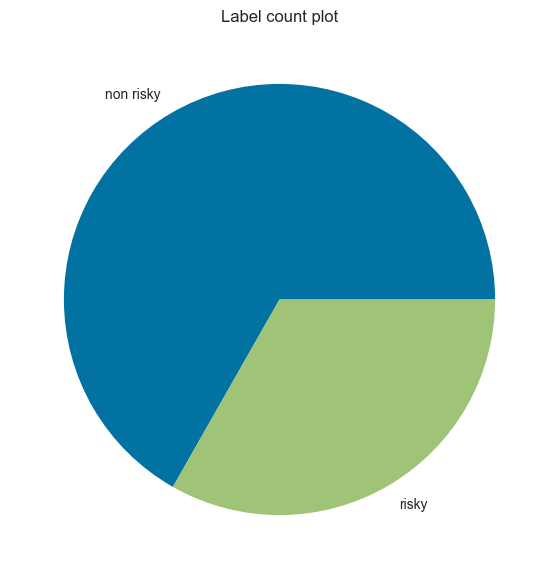

In [126]:
# Create new labels in the cleaned_dataset colunm

keys = ['non risky', 'risky'] # plotting a pie chart on label Colunm
     
plt.figure(figsize = (10,7))
plt.pie(df['label'].value_counts(), labels = keys)
plt.title('Label count plot')
plt.show() 



While analyzing the data, I noticed a significant imbalance in favor of the non-risky dataset, which could potentially affect our modeling results. To address this, I presented two options: 
1. Sklearn's Random Undersampling technique and 
2. merging additional datasets to balance the data. 

After careful consideration, we decided to implement Sklearn's Random Undersampling technique. This approach will help create a more balanced dataset, improving the accuracy and reliability of our risk modeling efforts.

In [127]:
# Length of sentence shown by Histograph
data = df_all['clean_sentence_EDA']
counts = []
# count words to gain insights
for sentence in df_all['clean_sentence_EDA']:
    sentence = word_tokenize(str(sentence))
    word_count = len(sentence)
    counts.append(word_count)


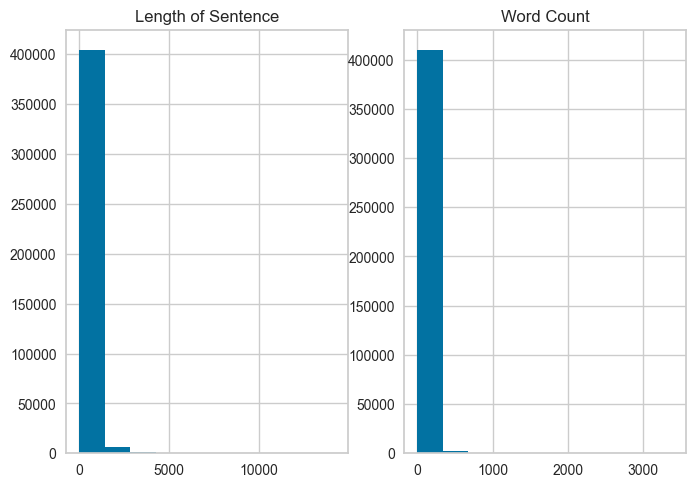

In [128]:

fig, axes = plt.subplots(1, 2)
data.str.len().hist(ax=axes[0]).set_title('Length of Sentence').bins=30
plt.title('Word Count')
plt.hist(counts)
plt.show()



In [129]:
## Text Metrix A. total_num_words, B.average_word_length, C.average_sentence_length

total_num_words= sum(counts)
average_sentence_length= np.mean(counts)

word_length=[]
for sentence in df_all['clean_sentence_EDA']:
    sentence= word_tokenize(str(sentence))
    for word in sentence:
        length=len(word)
        word_length.append(length)
average_word_length=np.mean(word_length)

print(f'Total number of words in the dataset: {total_num_words} words.')
print(f'Average length of sentences in the dataset: {average_sentence_length} words.')
print(f'Average length of words in the sentence: {average_word_length} characters')






Total number of words in the dataset: 14207440 words.
Average length of sentences in the dataset: 34.38060207143548 words.
Average length of words in the sentence: 6.032270838377639 characters


# Total number of words in the dataset: 15910784 words.
# Average length of sentences in the dataset: 38.50 words.
# Average length of words in the sentence: 5.62 characters

In [130]:
# Most frequent words before and after data processing/cleaning
all_words=[]
df_all_toxic_word=df_all[df_all['label']==1]['clean_sentence_EDA']
for sentence in df_all_toxic_word:
    words= word_tokenize(str(sentence))
    for word in words:
        all_words.append(word)
print(all_words[0:100])

['ask', 'native', 'Americans', 'take', 'Go', 'home', 'drunk', 'MAGA', 'Trump', 'Someone', 'veTaken', 'piece', 'shit', 'volcano', 'Liberals', 'Kookoo', 'Oh', 'no', 'Tough', 'shit', 'literally', 'talking', 'lol', 'mass', 'shooting', 'like', 'set', 'ups', 'propaganda', 'used', 'divide', 'u', 'major', 'issue', 'like', 'gun', 'control', 'terrorism', 'Canada', 'need', 'another', 'CUCK', 'already', 'enough', 'LooneyLeft', 'Liberals', 'f', 'king', 'great', 'country', 'Qproofs', 'TrudeauMustGo', 'lying', 'corrupt', 'traitor', 'Nobody', 'want', 'hear', 'anymore', 'lie', 'DeepStateCorruption', 'gun', 'control', 'kid', 'asking', 'LOL', 'Throwing', 'BULLSHIT', 'Flag', 'nonsense', 'PutUpOrShutUp', 'Kavanaugh', 'MAGA', 'CallTheVoteAlready', 'Kind', 'like', 'conservative', 'wan', 'na', 'associate', 'everyone', 'left', 'communist', 'antifa', 'member', 'Da', 'fuck', 'going', 'people', 'men', 'room', 'woman', 'room', 'Pick', 'one', 'stick', 'w', 'Tbh', 'day', 'like']


In [131]:
df_all.shape

(413240, 7)

In [132]:
# let us find the 20 most common words now (after second round of pre-processing)

most_common = Counter(all_words).most_common(20)
print(most_common)


[('fuck', 19515), ('FUCK', 14600), ('like', 11183), ('SUCK', 10888), ('NIGGER', 8951), ('as', 8718), ('faggot', 7602), ('know', 7405), ('shit', 7239), ('page', 7026), ('FAT', 6948), ('u', 6895), ('SHIT', 6724), ('DIE', 6576), ('JEW', 6221), ('nigger', 6031), ('hate', 5933), ('fucking', 5862), ('people', 5765), ('moron', 5678)]


In [133]:

# word frequency after second round of pre-processing

words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    


<AxesSubplot: >

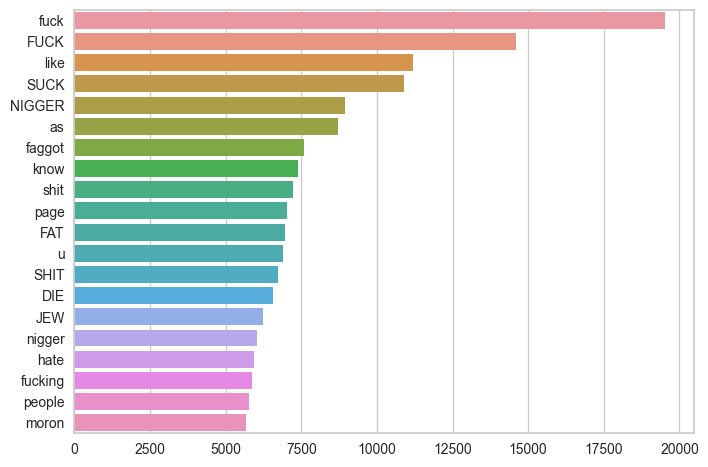

In [134]:
sns.barplot(x = frequency, y = words)

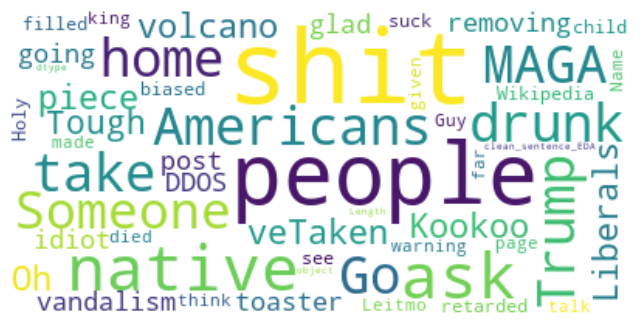

In [135]:
# create a word cloud (for risky sentence)

word_cloud = WordCloud(collocations=False, background_color='white').generate(str(df_all[df_all['label'] == 1]['clean_sentence_EDA']))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Step3 Modelling (3a train test split and 3b Model application)

In [136]:
from  imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
from sklearn.metrics import confusion_matrix





In [137]:
dataset= pd.read_csv("/Users/naveenkhajuria/Purti_Coding/egypt/veer_sub/combine_clean.csv")
dataset.shape
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)


## Step3a Splitting the text data into training and validation using sklearn train_test_split

In [138]:
X_train, X_test, y_train, y_test= train_test_split(dataset['clean_sentence_training'], dataset['label'], test_size=0.2, random_state=42)

In [139]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((330478,), (82620,), (330478,), (82620,))

## Step 3b Modelling

Modelling steps involved in the analysis are as follows: 

1.  Create a pipeline with TF-IDF transformation and logistic regression for classification

2. Train the model without utilizing random undersampling to evaluate the performance on the non-balanced dataset (#pipeline1 without applying imbalance randomsampling technique and #pipeline with imbalance randomsampling)

3. Compare the model's performance on the balanced dataset, obtained by applying random undersampling, with the performance on the non-balanced dataset to assess the impact of dataset balancing on model performance

In [140]:

# First without imbalance randomsampling application

pipeline1= ImbalancedPipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.7)),
    ('classifier', LogisticRegression(multi_class='ovr', max_iter=1000))
])

# Fit the pipe line to the training data
pipeline1.fit(X_train, y_train)

# Predict on the test data
y_pred= pipeline1.predict(X_test)

print(classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     72450
           1       0.88      0.63      0.74     10170

    accuracy                           0.94     82620
   macro avg       0.91      0.81      0.85     82620
weighted avg       0.94      0.94      0.94     82620

0.944081336238199


## Step 4 Ploting the Confusion Matrix

<AxesSubplot: >

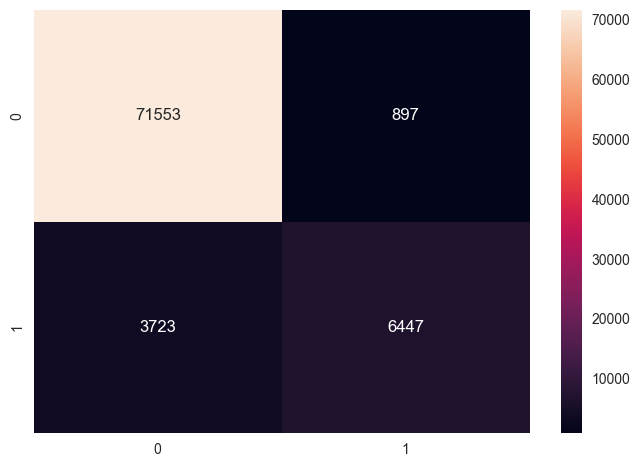

In [141]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')


In [142]:
# Second pipeline with imbalance randonsampling technique application

lgmodel = LogisticRegression(multi_class='ovr', max_iter=1000)
pipeline= ImbalancedPipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.7)),
    ('random_undersampling', RandomUnderSampler()),
    ('classifier', lgmodel)
])

# Fit the pipe line to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred= pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     72450
           1       0.59      0.88      0.71     10170

    accuracy                           0.91     82620
   macro avg       0.79      0.90      0.83     82620
weighted avg       0.93      0.91      0.92     82620

0.9112321471798596


<AxesSubplot: >

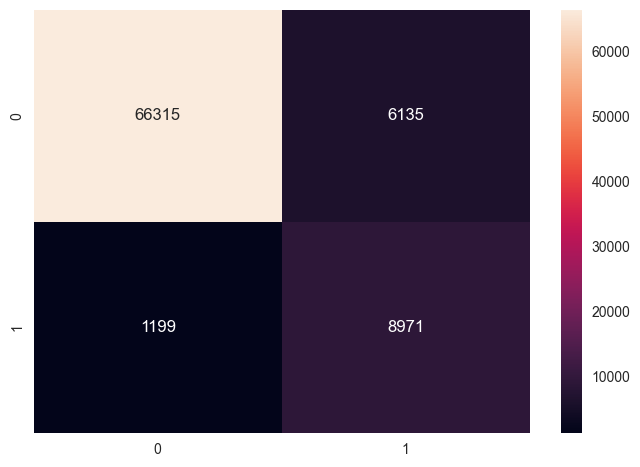

In [143]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

 

Data insights and learnings

1. Dataset skew: The dataset had a higher number of non-risky sentences compared to risky sentences, indicating an imbalance in the data.

2. Dataset balancing: To address the dataset imbalance and improve performance, Sklearn's undersampling technique was applied. This involved reducing instances in the majority class (non-risky sentences).

3. Pipeline implementation: A pipeline was developed to handle the imbalanced nature of the dataset, ensuring that the model considers this characteristic during training.

4. Initial model performance: Before correcting the data imbalance, the model was evaluated. The recall for the risky class (1) was found to be 0.63, indicating that the model correctly identified only 63% of the actual risky sentences.

5. RandomUndersampling impact: After applying the RandomUndersampling technique to balance the dataset, the recall for the risky class improved to 88% from 63%. This improvement addressed the issue of poor performance for the minority class (risky sentences) caused by algorithmic bias towards the dominant class.

6. Benefits of undersampling: Undersampling allowed the model to focus on the minority class, enhancing pattern learning and overall performance.

7. Model selection: Logistic regression was initially chosen as the classification model for this problem. However, alternative models can be considered based on specific project requirements and goals.




Some additional work that could be considered includes 
1. Implementing stratified k-fold for the train-test split to address dataset skewness, and assessing it's performance compared to base model i.e. ogistic regression. This approach ensures balanced class distribution.
2. Explore alternative algorithms (e.g., decision trees, random forests), and provides insights into potential improvements in prediction accuracy.
3. Explore applying other techniques for imbalance dataset from SKlearn library



In [144]:
import pickle
with open('mytoxiccomentlgmodel.pickle', 'wb') as f:
    pickle.dump(pipeline,f)